# 0. Imports

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import utils as util

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# 1. Preamble analysis of the dataset

In [2]:
df = pd.read_csv("./data/covid_data.csv")
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


### 1.1 Analysing existing data

In [3]:
df_null = df.copy()
for i in [97, 98, 99]:
   df_null.replace(i , np.nan, inplace = True)

In [4]:
df_null.isnull().sum()

USMER                        0
MEDICAL_UNIT                 0
SEX                          0
PATIENT_TYPE                 0
DATE_DIED                    0
INTUBED                 855869
PNEUMONIA                16003
AGE                        345
PREGNANT                527265
DIABETES                  3338
COPD                      3003
ASTHMA                    2979
INMSUPR                   3404
HIPERTENSION              3104
OTHER_DISEASE             5045
CARDIOVASCULAR            3076
OBESITY                   3032
RENAL_CHRONIC             3006
TOBACCO                   3220
CLASIFFICATION_FINAL         0
ICU                     856032
dtype: int64

As we can show with the following graph, there are **a lot** of NA values in the dataset. We will have to handle them.

One approach is to take the mean of the column and replace the NA values with it. However, this is not a good approach, as it will skew the data. We will have to find a better way to handle the NA values.

We will therefore have to go each problematic columun to fix the eventual problematic data

Remember that in the dataset definition it says that 97,98 and 99 are null values, let's deal with that

In [5]:
# sns.heatmap(df_null.isnull(), cbar=False)
# plt.title('Before data cleanup', color = 'black', fontsize = 15)
# plt.show()

#### As we can see, that's no bueno...

In [6]:
df.describe().round(3).T.drop('count', axis = 1)

,mean,std,min,25%,50%,75%,max
USMER,1.632,0.482,1.0,1.0,2.0,2.0,2.0
MEDICAL_UNIT,8.981,3.723,1.0,4.0,12.0,12.0,13.0
SEX,1.499,0.500,1.0,1.0,1.0,2.0,2.0
PATIENT_TYPE,1.191,0.393,1.0,1.0,1.0,1.0,2.0
INTUBED,79.523,36.869,1.0,97.0,97.0,97.0,99.0
PNEUMONIA,3.347,11.913,1.0,2.0,2.0,2.0,99.0
AGE,41.794,16.907,0.0,30.0,40.0,53.0,121.0
PREGNANT,49.766,47.511,1.0,2.0,97.0,97.0,98.0
DIABETES,2.186,5.424,1.0,2.0,2.0,2.0,98.0
COPD,2.261,5.132,1.0,2.0,2.0,2.0,98.0


Furthermore, we have some suspiciously skewed data. Is really half of the population pregnant?!

### 1.2 Managing the DEAD people 

People with a DATE_DIED value of 9999-99-99 simply aren't dead, so we'll just create a new DEAD column to represent that

In [7]:
# Check for any strings in the feature "DATE_DIED"
df['DATE_DIED'][df['DATE_DIED'].apply(lambda x: isinstance(x, str))]

0          03/05/2020
1          03/06/2020
2          09/06/2020
3          12/06/2020
4          21/06/2020
              ...    
1048570    9999-99-99
1048571    9999-99-99
1048572    9999-99-99
1048573    9999-99-99
1048574    9999-99-99
Name: DATE_DIED, Length: 1048575, dtype: object

In [8]:
df['DEAD'] = [2 if i=='9999-99-99' else 1 for i in df.DATE_DIED]

In [9]:
df['DEAD'].value_counts(normalize=True)

DEAD
2    0.926622
1    0.073378
Name: proportion, dtype: float64

We'll also replace 9999-99-99 with NaN for the time being

In [10]:
df = df.drop('DATE_DIED', axis=1)

#### How does the data look now ?

In [11]:
df.describe().round(3).T.drop('count', axis = 1)


,mean,std,min,25%,50%,75%,max
USMER,1.632,0.482,1.0,1.0,2.0,2.0,2.0
MEDICAL_UNIT,8.981,3.723,1.0,4.0,12.0,12.0,13.0
SEX,1.499,0.500,1.0,1.0,1.0,2.0,2.0
PATIENT_TYPE,1.191,0.393,1.0,1.0,1.0,1.0,2.0
INTUBED,79.523,36.869,1.0,97.0,97.0,97.0,99.0
PNEUMONIA,3.347,11.913,1.0,2.0,2.0,2.0,99.0
AGE,41.794,16.907,0.0,30.0,40.0,53.0,121.0
PREGNANT,49.766,47.511,1.0,2.0,97.0,97.0,98.0
DIABETES,2.186,5.424,1.0,2.0,2.0,2.0,98.0
COPD,2.261,5.132,1.0,2.0,2.0,2.0,98.0


Hmmm, it looks like we'll have to work on the PREGNANT, ICU, and INTUBED people

### 1.3 SEX Values

We'll just set the 1 and 2 values to "Female" and "Male" respectively

### 1.4 Pregnant values

In [12]:
df.SEX.value_counts()

SEX
1    525064
2    523511
Name: count, dtype: int64

In [13]:
df.SEX.shape

(1048575,)

Pregnant females ?

In [14]:
df[(df['SEX'] == 1)]['PREGNANT']

0          2
3          2
5          2
6          2
7          2
          ..
1048563    2
1048564    2
1048565    2
1048567    2
1048569    2
Name: PREGNANT, Length: 525064, dtype: int64

In [15]:
df[(df['SEX'] == 1)]['PREGNANT'].value_counts()

PREGNANT
2     513179
1       8131
98      3754
Name: count, dtype: int64

Pregnant males ?

In [16]:
df[(df['SEX'] == 2)]['PREGNANT']

1          97
2          97
4          97
11         97
12         97
           ..
1048570    97
1048571    97
1048572    97
1048573    97
1048574    97
Name: PREGNANT, Length: 523511, dtype: int64

In [17]:
df[(df['SEX'] == 2) & (df['PREGNANT'])]['PREGNANT'].value_counts()

PREGNANT
97    523511
Name: count, dtype: int64

In [18]:
df['PREGNANT'].value_counts()

PREGNANT
97    523511
2     513179
1       8131
98      3754
Name: count, dtype: int64

It looks like 97 indicates males that aren't pregnant. In other words, for those values we can just input 2 instead of 97

In [19]:
df['PREGNANT'].replace (97, 2, inplace = True)

Finally, 98 represents the females that are unknown to be pregnant or not

In [20]:
df['PREGNANT'].value_counts()

PREGNANT
2     1036690
1        8131
98       3754
Name: count, dtype: int64

We can simply mark then as NA as the data is logically Not Available

In [21]:
df['PREGNANT'].replace(98, None, inplace = True)
df['PREGNANT'].value_counts(normalize=True)

PREGNANT
2    0.992218
1    0.007782
Name: proportion, dtype: float64

Most people aren't pregnant, this now makes a lot more sense

### 1.5 ICU values

In [22]:
df.ICU.value_counts()

ICU
97    848544
2     175685
1      16858
99      7488
Name: count, dtype: int64

In [23]:
pd.crosstab(df['PATIENT_TYPE'], df['ICU'])

ICU,1,2,97,99
PATIENT_TYPE,,,,
1,0,0,848544,0
2,16858,175685,0,7488


From the above we can see that the missing values of 97 are all corresponding to the values of PATIENT_TYPE = 1 which is for non hospitalized patients, while those of 99 are the missing values of the hospitalized patients, which again can not be told or predicted.

So we can replace all the values of (97) with (2); since obviously patients who have never been hospitalized couldn't possibly be admitted to the ICU.

In [24]:
df['ICU'].replace (97, 2, inplace = True)

In [25]:
df.ICU.value_counts()

ICU
2     1024229
1       16858
99       7488
Name: count, dtype: int64

### 1.6 INTUBED values

In [26]:
df.INTUBED.value_counts()

INTUBED
97    848544
2     159050
1      33656
99      7325
Name: count, dtype: int64

In [27]:
pd.crosstab(df['PATIENT_TYPE'], df['INTUBED'])

INTUBED,1,2,97,99
PATIENT_TYPE,,,,
1,0,0,848544,0
2,33656,159050,0,7325


Same logic of the ICU patients: patients that are intubed necessarily are also hospitalized

In [28]:
df['INTUBED'].replace (97, 2, inplace = True)

In [29]:
df.INTUBED.value_counts()

INTUBED
2     1007594
1       33656
99       7325
Name: count, dtype: int64

We'll replace everything that we can't infer with NaN

In [30]:
for i in [98, 99]:
   df.replace(i , np.nan, inplace = True)

#### How does the data look now ?

In [31]:
# First, let's temporarily reverse the step we did on "DATE_DIED" feature; as they are not really missing:
df_null2 = df.copy()

#Let's check again for our missing values:
df_null2.isnull().sum()

USMER                       0
MEDICAL_UNIT                0
SEX                         0
PATIENT_TYPE                0
INTUBED                  7325
PNEUMONIA               16003
AGE                       210
PREGNANT                 3754
DIABETES                 3338
COPD                     3003
ASTHMA                   2979
INMSUPR                  3404
HIPERTENSION             3104
OTHER_DISEASE            5045
CARDIOVASCULAR           3076
OBESITY                  3032
RENAL_CHRONIC            3006
TOBACCO                  3220
CLASIFFICATION_FINAL        0
ICU                      7488
DEAD                        0
dtype: int64

In [32]:
df.describe().round(3).T.drop('count', axis = 1)

,mean,std,min,25%,50%,75%,max
USMER,1.632,0.482,1.0,1.0,2.0,2.0,2.0
MEDICAL_UNIT,8.981,3.723,1.0,4.0,12.0,12.0,13.0
SEX,1.499,0.500,1.0,1.0,1.0,2.0,2.0
PATIENT_TYPE,1.191,0.393,1.0,1.0,1.0,1.0,2.0
INTUBED,1.968,0.177,1.0,2.0,2.0,2.0,2.0
PNEUMONIA,1.864,0.342,1.0,2.0,2.0,2.0,2.0
AGE,41.783,16.890,0.0,30.0,40.0,53.0,121.0
DIABETES,1.880,0.324,1.0,2.0,2.0,2.0,2.0
COPD,1.986,0.119,1.0,2.0,2.0,2.0,2.0
ASTHMA,1.970,0.171,1.0,2.0,2.0,2.0,2.0


Looks much better already !
What about a heatmap ?

In [33]:
# sns.heatmap(df_null2.isnull(), cbar=False)
# plt.title('After Data cleanup', color = 'black', fontsize = 15)
# plt.show()

In [34]:
# fig, ax = plt.subplots(figsize=(20, 15))
# mask=np.triu(np.ones_like(df.corr()))
# sns.heatmap(df.corr(), mask = mask, annot = True, cmap = "Blues", vmin = -1, vmax = 1)
# plt.title('Data Correlation', color = 'black', fontsize = 30)
# plt.show()

### 1.7 Hospitalization

Hospitalization is described by the `PATIENT_TYPE` column. It has a value of either 1: at home or 2: in hospital. We can change this column to a boolean column which, instead of describing the patient type, will describe if the patient is hospitalized or not. That means that we will have to change the column name to `HOSPITALIZED`, but we'll also have to invert all the values.

In [35]:
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DEAD
0,2,1,1,1,2.0,1.0,65.0,2,2.0,2.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3,2.0,1
1,2,1,2,1,2.0,1.0,72.0,2,2.0,2.0,...,2.0,1.0,2.0,2.0,1.0,1.0,2.0,5,2.0,1
2,2,1,2,2,1.0,2.0,55.0,2,1.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0,1
3,2,1,1,1,2.0,2.0,53.0,2,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7,2.0,1
4,2,1,2,1,2.0,2.0,68.0,2,1.0,2.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3,2.0,1


In [36]:
df["HOSPITALIZED"] = [1 if i == 2 else 2 for i in df["PATIENT_TYPE"]]
df[["HOSPITALIZED", "PATIENT_TYPE"]].head()

,HOSPITALIZED,PATIENT_TYPE
0,2,1
1,2,1
2,1,2
3,2,1
4,2,1


We'll drop the column as it is now redundant

In [37]:
df = df.drop("PATIENT_TYPE", axis=1)
df.head()

,USMER,MEDICAL_UNIT,SEX,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,...,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DEAD,HOSPITALIZED
0,2,1,1,2.0,1.0,65.0,2,2.0,2.0,2.0,...,1.0,2.0,2.0,2.0,2.0,2.0,3,2.0,1,2
1,2,1,2,2.0,1.0,72.0,2,2.0,2.0,2.0,...,1.0,2.0,2.0,1.0,1.0,2.0,5,2.0,1,2
2,2,1,2,1.0,2.0,55.0,2,1.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0,1,1
3,2,1,1,2.0,2.0,53.0,2,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,7,2.0,1,2
4,2,1,2,2.0,2.0,68.0,2,1.0,2.0,2.0,...,1.0,2.0,2.0,2.0,2.0,2.0,3,2.0,1,2


### 1.8 Readability fix

As we can see, the column names are not very readable, so we'll just fix that. In the original datasheet, it is said that the boolean values, 1 and 2, are actually "Yes" and "No" respectively. We'll just change that as well to make them boolean.

In [38]:
# Get columns whose data unique count is equal to 2 and are either 1, 2 or NA
binary_cols = [col for col in df.columns if df[col].nunique() == 2 and df[col].dropna().value_counts().index.isin([1,2]).all()]
binary_cols

['USMER',
 'SEX',
 'INTUBED',
 'PNEUMONIA',
 'PREGNANT',
 'DIABETES',
 'COPD',
 'ASTHMA',
 'INMSUPR',
 'HIPERTENSION',
 'OTHER_DISEASE',
 'CARDIOVASCULAR',
 'OBESITY',
 'RENAL_CHRONIC',
 'TOBACCO',
 'ICU',
 'DEAD',
 'HOSPITALIZED']

The number of boolean columns described in the datasheet is 15, but we have 16. The culprit is the `USMER` column, which does have only two values, but do not describe a boolean value. We'll just remove it from the list.

In [39]:
binary_cols.remove("USMER")
binary_cols

['SEX',
 'INTUBED',
 'PNEUMONIA',
 'PREGNANT',
 'DIABETES',
 'COPD',
 'ASTHMA',
 'INMSUPR',
 'HIPERTENSION',
 'OTHER_DISEASE',
 'CARDIOVASCULAR',
 'OBESITY',
 'RENAL_CHRONIC',
 'TOBACCO',
 'ICU',
 'DEAD',
 'HOSPITALIZED']

Now that we have a list of boolean value columns, we can change the values to strings of either "Y" or "N" and then change the column type to categorical.

In [40]:
# Change the values of the binary columns to "Y" if 1, "N" if 2
# for col in binary_cols:
#     df[col] = df[col].replace({1: "Y", 2: "N"})
# df.describe().round(3).T.drop('count', axis = 1)

### 1.9 Categorizing the columns

In [41]:
# For every columns, display the number of unique values
df.nunique()

USMER                     2
MEDICAL_UNIT             13
SEX                       2
INTUBED                   2
PNEUMONIA                 2
AGE                     119
PREGNANT                  2
DIABETES                  2
COPD                      2
ASTHMA                    2
INMSUPR                   2
HIPERTENSION              2
OTHER_DISEASE             2
CARDIOVASCULAR            2
OBESITY                   2
RENAL_CHRONIC             2
TOBACCO                   2
CLASIFFICATION_FINAL      7
ICU                       2
DEAD                      2
HOSPITALIZED              2
dtype: int64

In [42]:
non_categorical = ["AGE"]
categorical = df.columns.drop(non_categorical)

for category in categorical:
    df[category].astype("category")
    
df.describe().round(3).T.drop('count', axis = 1)



,mean,std,min,25%,50%,75%,max
USMER,1.632,0.482,1.0,1.0,2.0,2.0,2.0
MEDICAL_UNIT,8.981,3.723,1.0,4.0,12.0,12.0,13.0
SEX,1.499,0.500,1.0,1.0,1.0,2.0,2.0
INTUBED,1.968,0.177,1.0,2.0,2.0,2.0,2.0
PNEUMONIA,1.864,0.342,1.0,2.0,2.0,2.0,2.0
AGE,41.783,16.890,0.0,30.0,40.0,53.0,121.0
DIABETES,1.880,0.324,1.0,2.0,2.0,2.0,2.0
COPD,1.986,0.119,1.0,2.0,2.0,2.0,2.0
ASTHMA,1.970,0.171,1.0,2.0,2.0,2.0,2.0
INMSUPR,1.986,0.116,1.0,2.0,2.0,2.0,2.0


## Dealing with null data

In [43]:
# Select only the categorical columns from the DataFrame
categorical_data = df[categorical]

# Count the total number of rows in the categorical_data DataFrame
total_rows = len(categorical_data)

# Count the number of null values in each categorical column
null_rows_count = categorical_data.isnull().sum()

# Calculate the percentage of null values for each column
percentage_null_values = (null_rows_count / total_rows) * 100

# Create a DataFrame to display the results
null_summary = pd.DataFrame({
    'Null Values Count': null_rows_count,
    'Total Values Count': total_rows,
    'Percentage of Null Values': percentage_null_values
})

# Print the summary
print("Summary of null values in each categorical column:")
print(null_summary)


Summary of null values in each categorical column:
                      Null Values Count  Total Values Count  \
USMER                                 0             1048575   
MEDICAL_UNIT                          0             1048575   
SEX                                   0             1048575   
INTUBED                            7325             1048575   
PNEUMONIA                         16003             1048575   
PREGNANT                           3754             1048575   
DIABETES                           3338             1048575   
COPD                               3003             1048575   
ASTHMA                             2979             1048575   
INMSUPR                            3404             1048575   
HIPERTENSION                       3104             1048575   
OTHER_DISEASE                      5045             1048575   
CARDIOVASCULAR                     3076             1048575   
OBESITY                            3032             1048575   
RENA

In [44]:
# Calculate the initial number of rows
initial_rows = len(categorical_data)

# Remove rows with null values
categorical_data_cleaned = categorical_data.dropna()

# Calculate the number of removed lines
removed_lines = initial_rows - len(categorical_data_cleaned)

# Calculate the number of lines that remain after removal
remaining_lines = len(categorical_data_cleaned)

# Print the number of removed lines and remaining lines
print(f"Number of removed lines: {removed_lines}")
print(f"Number of lines remaining: {remaining_lines}")

# Optionally, you can assign the cleaned DataFrame to a new variable or overwrite the original one
# categorical_data = categorical_data_cleaned


Number of removed lines: 28909
Number of lines remaining: 1019666


In [45]:
# Calculate the number of rows to export (10% of the total cleaned data)
# percentage_to_export = 0.1
# num_rows_to_export = int(len(categorical_data_cleaned) * percentage_to_export)

# Set a random seed for reproducibility
# random_seed = 42  # You can use any integer as the seed

# Use the sample method to randomly select the specified number of rows
# random_subset = categorical_data_cleaned.sample(n=num_rows_to_export, random_state=random_seed)

# Specify the path where you want to save the cleaned subset of data to a CSV file
# cleaned_subset_output_file = "cleaned_categorical_data_subset.csv"

# Export the cleaned subset of data to a CSV file
# random_subset.to_csv(cleaned_subset_output_file, index=False)

# Optionally, you can read the cleaned subset data back into a DataFrame if needed
# cleaned_subset_df = pd.read_csv(cleaned_subset_output_file)

# Display the first few rows of the cleaned subset DataFrame
# print("\nFirst few rows of the cleaned subset DataFrame:")
# print(cleaned_subset_df.head())

# Looking for correlation

In [46]:
# df = df[['USMER','MEDICAL_UNIT','SEX','INTUBED','PNEUMONIA','PREGNANT','DIABETES','COPD','ASTHMA','INMSUPR','HIPERTENSION','OTHER_DISEASE','CARDIOVASCULAR','OBESITY','RENAL_CHRONIC','TOBACCO','CLASIFFICATION_FINAL','ICU','DEAD','HOSPITALIZED'
# ]].dropna()



df.corr()['DEAD']


USMER                   0.112671
MEDICAL_UNIT            0.149030
SEX                    -0.081383
INTUBED                 0.503729
PNEUMONIA               0.471559
AGE                    -0.320765
PREGNANT               -0.021245
DIABETES                0.217199
COPD                    0.090238
ASTHMA                 -0.017670
INMSUPR                 0.050446
HIPERTENSION            0.204885
OTHER_DISEASE           0.057190
CARDIOVASCULAR          0.077024
OBESITY                 0.057684
RENAL_CHRONIC           0.119504
TOBACCO                 0.005999
CLASIFFICATION_FINAL    0.196085
ICU                     0.205733
DEAD                    1.000000
HOSPITALIZED            0.515582
Name: DEAD, dtype: float64

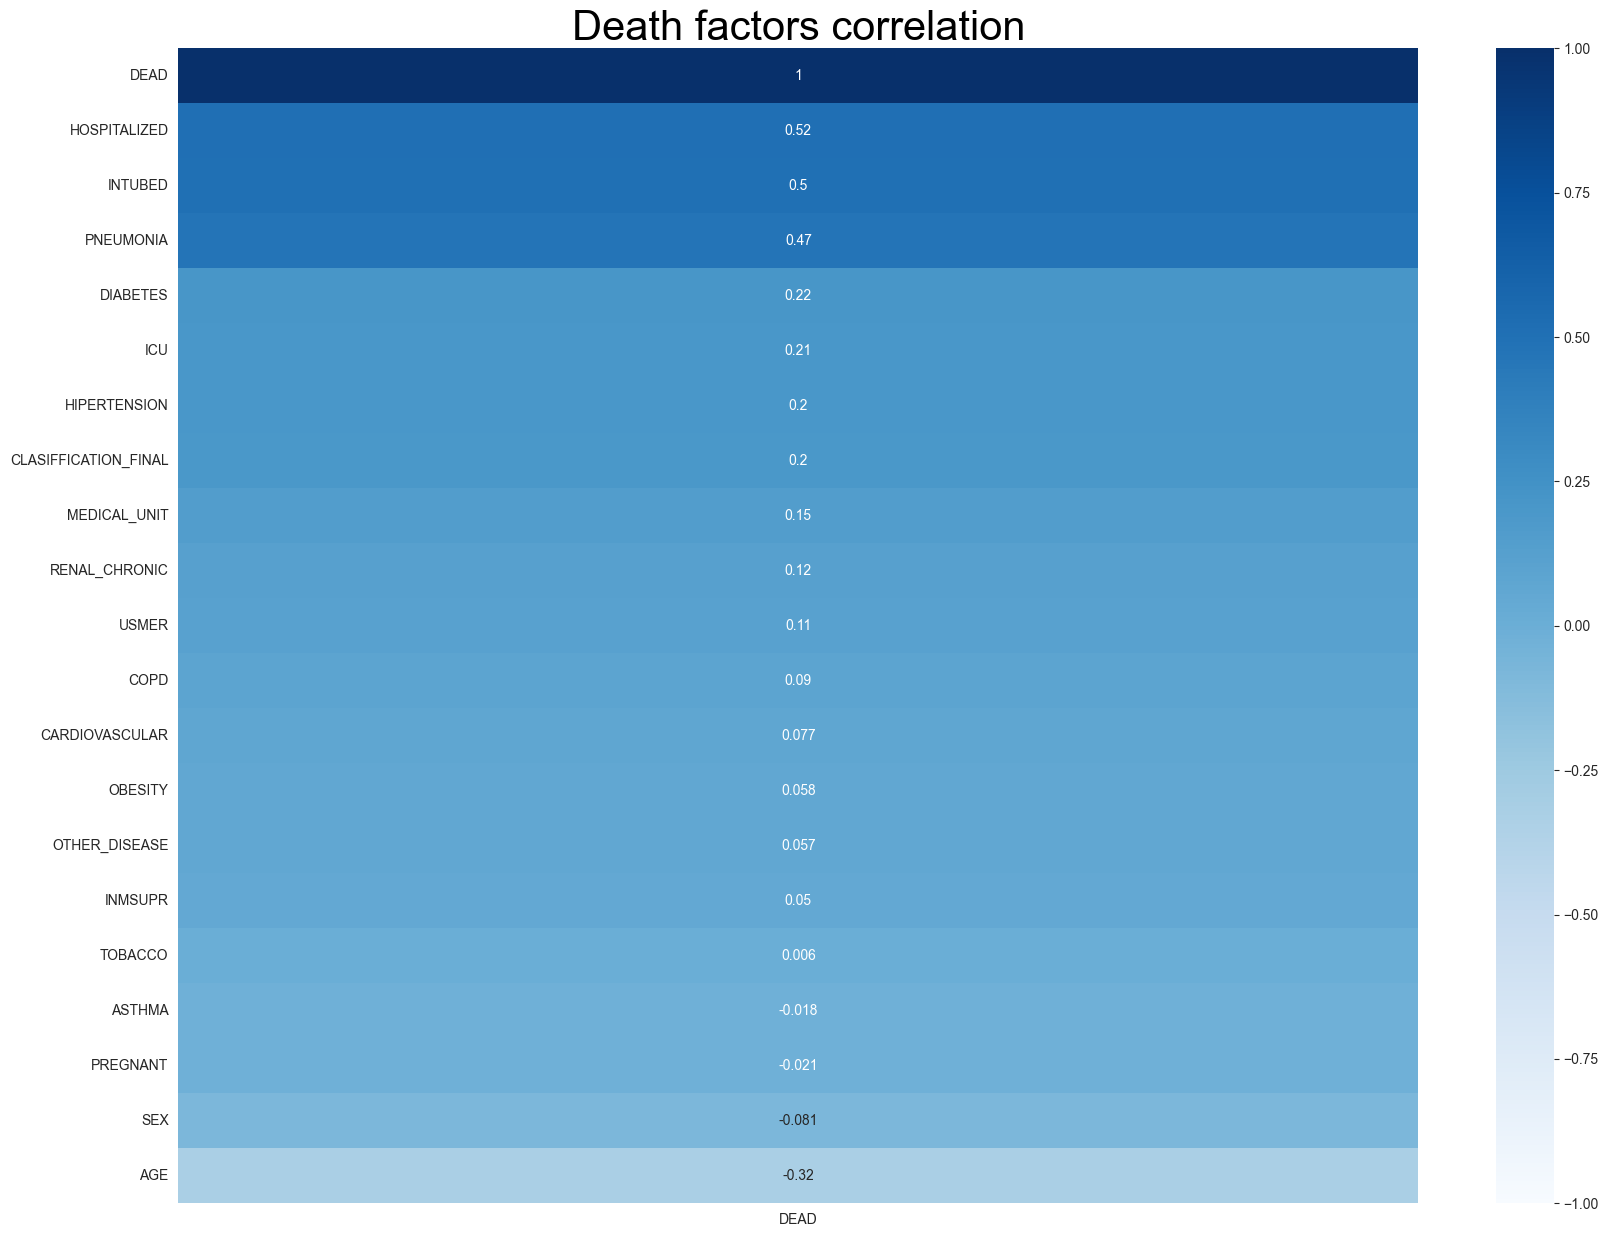

In [47]:
fig, ax = plt.subplots(figsize=(20, 15))
sorted_corr = df.copy()
sorted_corr = sorted_corr.corr()[['DEAD']].sort_values(by='DEAD', ascending=False)

sns.heatmap(sorted_corr, annot = True, cmap = "Blues", vmin = -1, vmax = 1)
plt.title('Death factors correlation', color = 'black', fontsize = 30)
plt.show()

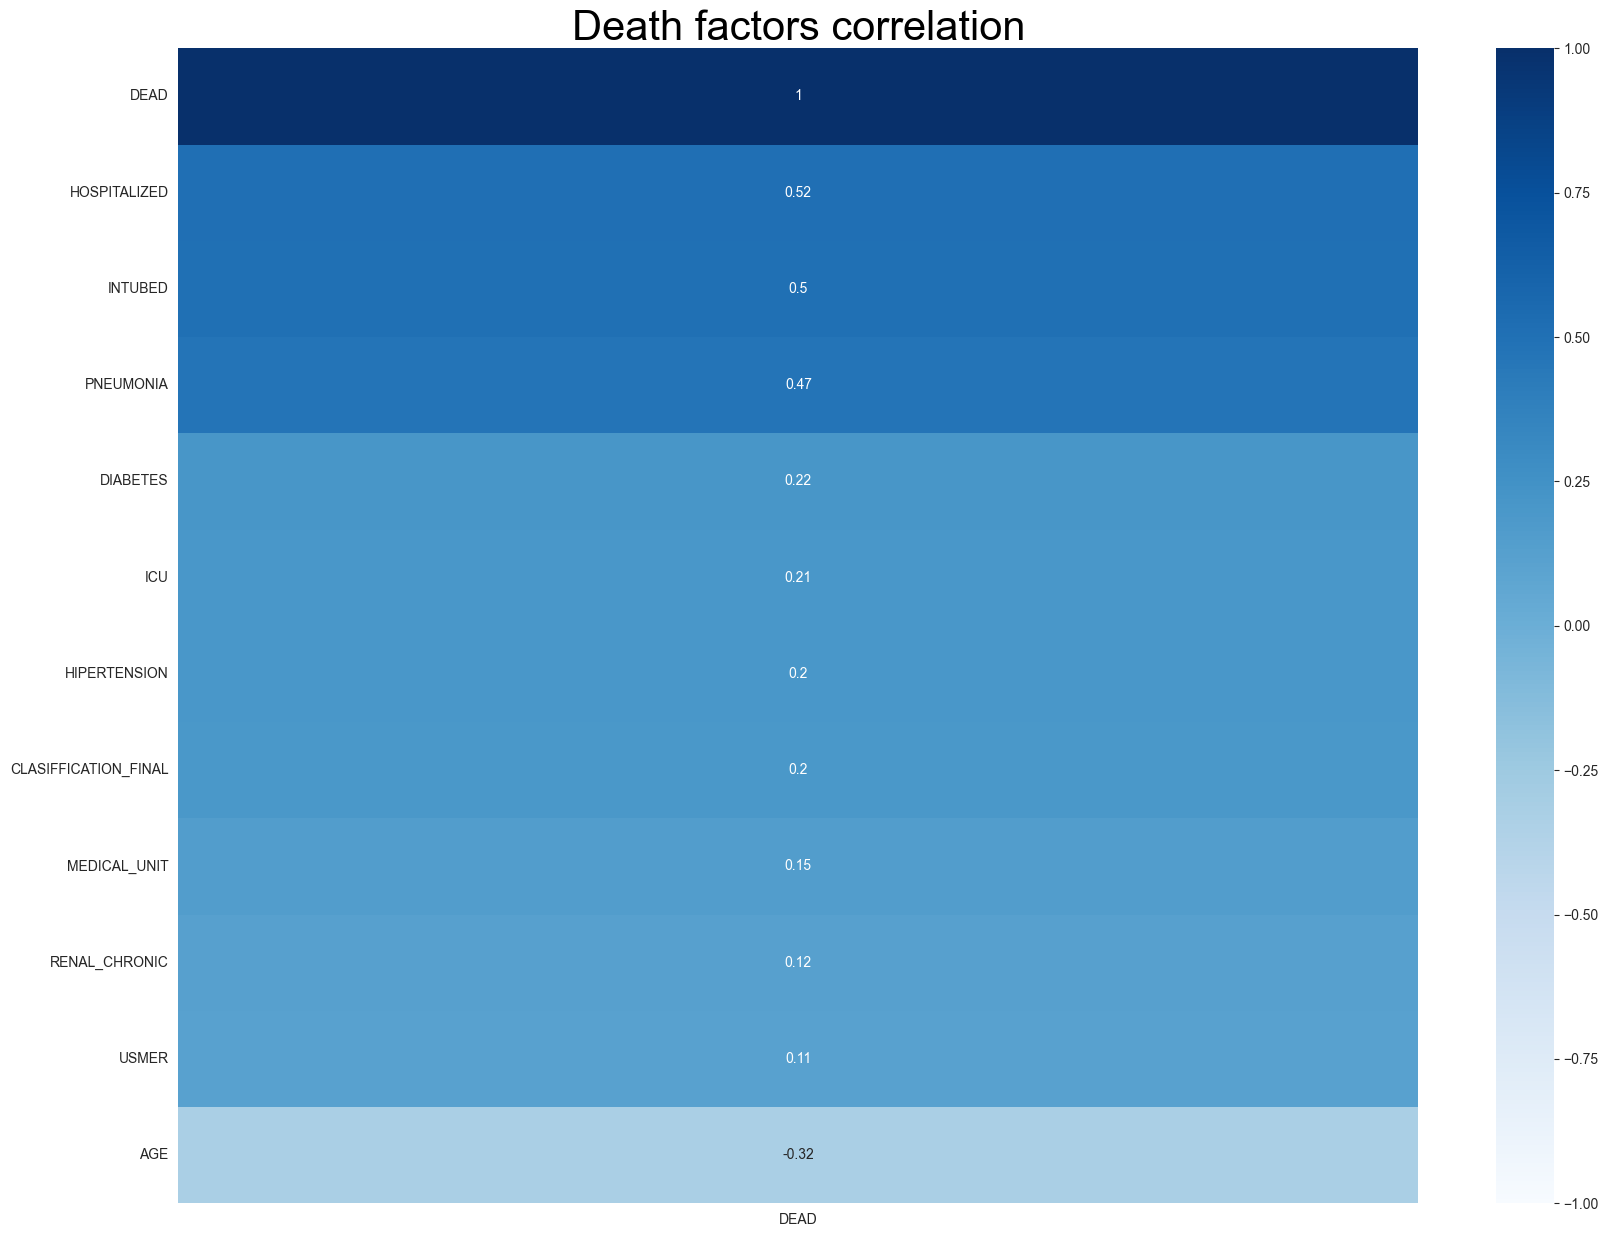

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

sorted_corr_relevant = df.copy()
correlation_matrix = sorted_corr_relevant.corr()[['DEAD']]

filtered_corr = correlation_matrix[(correlation_matrix > 0.1) | (correlation_matrix < -0.1)].dropna()

fig, ax = plt.subplots(figsize=(20, 15))

sns.heatmap(filtered_corr.sort_values(by='DEAD', ascending=False), annot=True, cmap="Blues", vmin=-1, vmax=1)
plt.title('Death factors correlation', color='black', fontsize=30)
plt.show()


# Decision tree

## Basic example

In [49]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

X = df.copy().drop('DEAD', axis=1)
Y = df['DEAD']

In [50]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

dtree = DecisionTreeClassifier()
dtree = dtree.fit(x_train, y_train)

In [51]:
print("Decision Tree Train Accuracy: ", dtree.score(x_train,y_train), "\n")
print("Decision Tree Test Accuracy:", dtree.score(x_test, y_test), "\n")

Decision Tree Train Accuracy:  0.9695041702883643 
Decision Tree Test Accuracy: 0.9409962075575463 


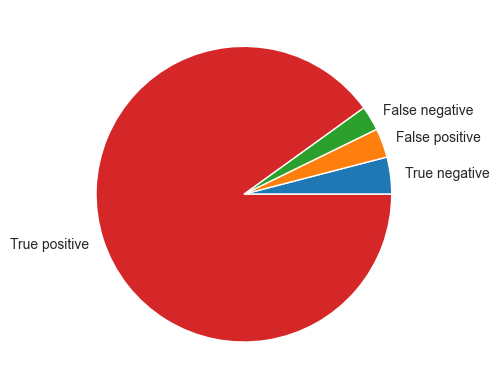

In [52]:
y_pred = dtree.predict(x_test)
c_matrix = confusion_matrix(y_test, y_pred)
util.plot_confusion_matrix_pie(c_matrix)

## Correlation based Tree data selection

Here I just select the more relevant columns based on the correlation results.

In [68]:
bound = 0.4

sorted_corr.sort_values(by='DEAD', ascending=False)

filtered_corr = sorted_corr[(sorted_corr['DEAD'] > bound) | (sorted_corr['DEAD'] < -bound)]

filtered_corr.sort_values(by='DEAD', ascending=False)

unique_names = filtered_corr.index.tolist()

unique_names.remove('DEAD')

unique_names

['HOSPITALIZED', 'INTUBED', 'PNEUMONIA']

In [69]:
from sklearn.tree import DecisionTreeClassifier

X = df[unique_names].copy()

Y = df['DEAD']

In [70]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

dtree = DecisionTreeClassifier()
dtree = dtree.fit(x_train, y_train)

In [71]:
print("Decision Tree Train Accuracy: ", dtree.score(x_train,y_train), "\n")

print("Decision Tree Train Accuracy:", dtree.score(x_test, y_test), "\n")

Decision Tree Train Accuracy:  0.9445178623491489 

Decision Tree Train Accuracy: 0.9456024515772173 


[Text(0.5909090909090909, 0.875, 'HOSPITALIZED <= 1.5\ngini = 0.137\nsamples = 734002\nvalue = [54162, 679840]'),
 Text(0.36363636363636365, 0.625, 'INTUBED <= 1.5\ngini = 0.456\nsamples = 140343\nvalue = [49343, 91000]'),
 Text(0.18181818181818182, 0.375, 'PNEUMONIA <= 1.5\ngini = 0.338\nsamples = 23598\nvalue = [18518, 5080]'),
 Text(0.09090909090909091, 0.125, 'gini = 0.337\nsamples = 18064\nvalue = [14444, 3620]'),
 Text(0.2727272727272727, 0.125, 'gini = 0.374\nsamples = 5534\nvalue = [4074, 1460]'),
 Text(0.5454545454545454, 0.375, 'PNEUMONIA <= 1.5\ngini = 0.389\nsamples = 116745\nvalue = [30825, 85920]'),
 Text(0.45454545454545453, 0.125, 'gini = 0.442\nsamples = 63826\nvalue = [21036, 42790]'),
 Text(0.6363636363636364, 0.125, 'gini = 0.302\nsamples = 52919\nvalue = [9789, 43130]'),
 Text(0.8181818181818182, 0.625, 'PNEUMONIA <= 1.5\ngini = 0.016\nsamples = 593659\nvalue = [4819, 588840]'),
 Text(0.7272727272727273, 0.375, 'gini = 0.252\nsamples = 16179\nvalue = [2395, 13784]'

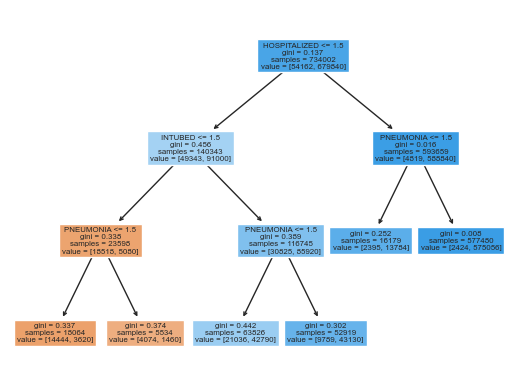

In [72]:
tree.plot_tree(dtree, feature_names=X.columns, filled=True)


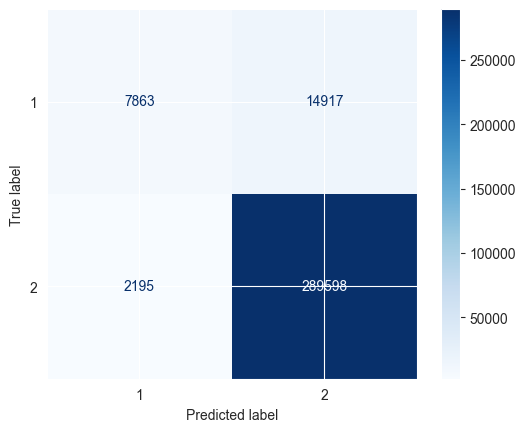

In [77]:
y_pred = dtree.predict(x_test)
c_matrix = confusion_matrix(y_test, y_pred, labels=["1", "2"])
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")

# Forest

In [79]:
X = df.copy().drop('DEAD', axis=1)
Y = df['DEAD']

X = X.fillna(X.mean())

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [80]:
dtree = RandomForestClassifier()
dtree = dtree.fit(x_train, y_train)

In [81]:
print("Decision Tree Train Accuracy: ", dtree.score(x_train,y_train), "\n")
print("Decision Tree Test Accuracy:", dtree.score(x_test, y_test), "\n")

Decision Tree Train Accuracy:  0.9771213157457337 
Decision Tree Test Accuracy: 0.9449253432430628 


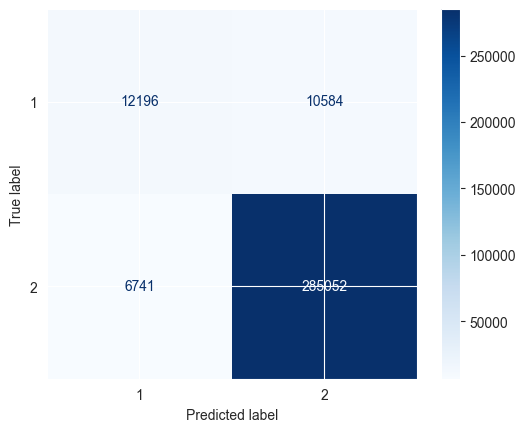

In [89]:
y_pred = dtree.predict(x_test)
c_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")

In [93]:
TP, FN, FP, TN = c_matrix.ravel()
print(TP, FN, FP, TN) 

12196 10584 6741 285052


In [99]:
N, P = y_test.value_counts().ravel()
print(N, P)

291793 22780


In [100]:
error_rate = (FP+FN)/(P+N)
error_rate

0.05507465675693718

In [101]:
accuracy = 1 - error_rate
accuracy

0.9449253432430629